### Preliminary Experiments

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from tqdm import tqdm
from tqdm import trange
import torch
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse import linalg
from pathlib import Path
import gc
import pickle

ModuleNotFoundError: No module named 'torch'

In [2]:
# === Load partial .npy file ===
# Only take first 10 time steps and first 8 variables
X_data = np.load('./data/truth_h_0.5_c_8_F_20.npy', mmap_mode='r')[:10, :8]
df_npy = pd.DataFrame(X_data)
print("Numpy Data (Partial):")
df_npy.head()

Numpy Data (Partial):


,0,1,2,3,4,5,6,7
0,-0.477061,-0.051036,-0.466878,-0.191163,-0.049380,-0.332908,-0.336403,-1.031654
1,-0.469257,-0.039944,-0.448651,-0.178676,-0.035969,-0.321362,-0.328982,-1.015027
2,-0.461080,-0.029067,-0.430044,-0.166131,-0.022420,-0.309783,-0.321967,-0.998652
3,-0.452243,-0.017692,-0.410987,-0.153687,-0.008846,-0.298471,-0.315278,-0.982594
4,-0.442997,-0.005505,-0.391538,-0.141262,0.004670,-0.287401,-0.308851,-0.966810


In [3]:
# === Load partial .csv file ===
# Only read first 10 rows
df_csv = pd.read_csv('./data/3tier_lorenz_v3.csv', nrows=10)
print("\nCSV Data (Partial):")
df_csv.head()


CSV Data (Partial):


,-0.41182,-1.1352,-0.27178,-0.090093,-0.97241,-0.61869,0.083132,-1.4884
0,-0.36659,-1.10660,-0.26038,-0.073788,-0.95847,-0.60283,0.096555,-1.4618
1,-0.32292,-1.07670,-0.24848,-0.057780,-0.94464,-0.58697,0.109560,-1.4345
2,-0.28086,-1.04550,-0.23614,-0.042091,-0.93091,-0.57110,0.122180,-1.4065
3,-0.24043,-1.01320,-0.22341,-0.026741,-0.91730,-0.55523,0.134420,-1.3779
4,-0.20165,-0.97991,-0.21035,-0.011753,-0.90380,-0.53936,0.146310,-1.3487


In [32]:
def whos_memory(namespace):
    exclude = {
        'np', 'pd', 'plt', 'os', 'gc', 'sys', 'sio', 'tqdm', 'torch', 'sparse', 'Path',
        'exit', 'quit', 'open', 'get_ipython', 'whos_memory'
    }
    print(f"{'Variable':20} {'Type':15} {'Size (MB)':>10}")
    print("-" * 50)
    for name, val in namespace.items():
        if name.startswith("_") or name in exclude:
            continue
        try:
            size = sys.getsizeof(val) / 1024 / 1024
            print(f"{name:20} {type(val).__name__:15} {size:10.4f}")
        except Exception:
            print(f"{name:20} {type(val).__name__:15} {'<unknown>'}")



# Run it like this:
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0004
Out                  dict                0.0002
delete_variables     function            0.0002
trange               function            0.0002
SAVE_DIR             str                 0.0001
shift_k              int                 0.0000
approx_res_size      int                 0.0000
model_params         dict                0.0002
res_params           dict                0.0003
generate_reservoir   function            0.0002
build_input_weights  function            0.0002
reservoir_layer      function            0.0002
train                function            0.0002
save_checkpoint      function            0.0002
load_latest_checkpoint function            0.0002
save_model           function            0.0002
predict              function            0.0002
dataf                DataFrame          61.0353
data                 ndarray       

In [10]:
def delete_variables(namespace):
    # Safe exclusions: libraries, system functions, your own helpers
    exclude = {
        # Standard libs
        'np', 'pd', 'plt', 'os', 'gc', 'sys', 'sio', 'tqdm', 'trange', 'torch', 'sparse', 'Path',
        # IPython internals
        'get_ipython', 'exit', 'quit', 'open', 'In', 'Out',
        # User-defined helpers
        'whos_memory', 'delete_variables'
    }

    for name in list(namespace):
        if name.startswith("_") or name.startswith("__") or name in exclude:
            continue
        try:
            del namespace[name]
        except Exception as e:
            print(f"Could not delete {name}: {e}")

    gc.collect()
    print("Deleted user variables and collected garbage.")


In [18]:
print("Before cleanup:")
whos_memory(globals())

Before cleanup:
Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0002
Out                  dict                0.0002
delete_variables     function            0.0002
trange               function            0.0002


In [15]:
delete_variables(globals())

Deleted user variables and collected garbage.


In [16]:
print("After cleanup:")
whos_memory(globals())

After cleanup:
Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0002
Out                  dict                0.0002
delete_variables     function            0.0002
trange               function            0.0002


### True Data

In [19]:
# === Load CSV ===
df_csv = pd.read_csv('./data/3tier_lorenz_v3.csv', header=None)
df_csv.head()

,0,1,2,3,4,5,6,7
0,-0.41182,-1.1352,-0.27178,-0.090093,-0.97241,-0.61869,0.083132,-1.4884
1,-0.36659,-1.1066,-0.26038,-0.073788,-0.95847,-0.60283,0.096555,-1.4618
2,-0.32292,-1.0767,-0.24848,-0.057780,-0.94464,-0.58697,0.109560,-1.4345
3,-0.28086,-1.0455,-0.23614,-0.042091,-0.93091,-0.57110,0.122180,-1.4065
4,-0.24043,-1.0132,-0.22341,-0.026741,-0.91730,-0.55523,0.134420,-1.3779


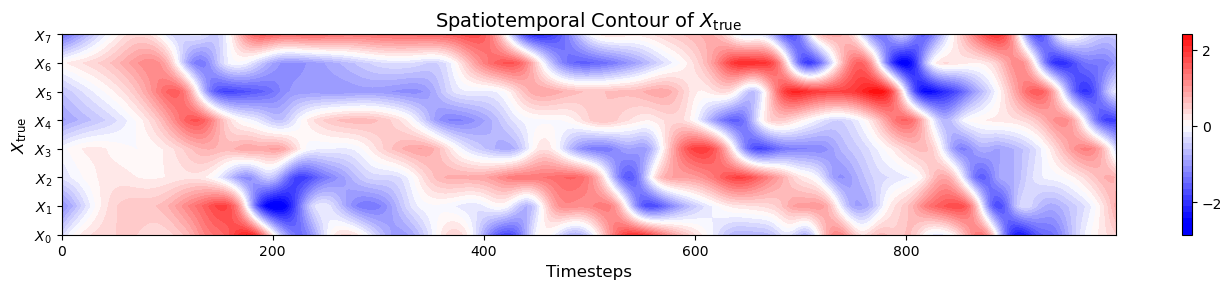

In [20]:
# === Slice 1000 steps ===
steps = 1000
X_plot = df_csv.iloc[:steps].to_numpy().T  # shape: (8, steps)

# === Axes ===
time_axis = np.arange(steps)  # use explicit timestep index
space_axis = np.arange(8)

# === Contour Plot ===
fig, ax = plt.subplots(figsize=(14, 3))
contour = ax.contourf(time_axis, space_axis, X_plot, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)

# === Labels ===
ax.set_title("Spatiotemporal Contour of $X_{\\mathrm{true}}$", fontsize=14)
ax.set_xlabel("Timesteps", fontsize=12)
ax.set_ylabel("$X_{\\mathrm{true}}$", fontsize=12)
ax.set_yticks(space_axis)
ax.set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])

# === Colorbar ===
cbar = fig.colorbar(contour, ax=ax)
cbar.set_ticks([-2, 0, 2])

plt.tight_layout()
plt.show()

In [21]:
# ===  Free memory ===
delete_variables(globals())
whos_memory(globals())

Deleted user variables and collected garbage.
Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0002
Out                  dict                0.0002
delete_variables     function            0.0002
trange               function            0.0002


### Imperfect Model

In [22]:
# === Constants ===
K = 8
J = 8
F = 20
h = 0.5
c = 8
b = 10
dt = 0.005
steps = 10000

# === Initial Condition from CSV ===
X_vec = np.array([-0.41182, -1.1352, -0.27178, -0.090093, -0.97241, -0.61869, 0.083132, -1.4884])
Y_mat = np.ones((J, K))  # dummy placeholder to keep step() working

# === Storage ===
x_store = np.zeros((steps, K))

# === Imperfect Step Function (Z excluded) ===
def step_imperfect(x_vec, y_mat):
    minus = [-1, 0, 1, 2, 3, 4, 5, 6]
    minus2 = [-2, -1, 0, 1, 2, 3, 4, 5]
    plus = [1, 2, 3, 4, 5, 6, 7, 0]
    plus2 = [2, 3, 4, 5, 6, 7, 0, 1]

    x_minus = x_vec[minus]
    x_minus2 = x_vec[minus2]
    x_plus = x_vec[plus]

    y_plus = y_mat[plus, :]
    y_plus2 = y_mat[plus2, :]
    y_minus = y_mat[minus, :]
    y_k = np.sum(y_mat, 0)

    dx = x_minus * (x_plus - x_minus2) - x_vec + F - (h * c / b) * y_k
    dy = -c * b * y_plus * (y_plus2 - y_minus) - c * y_mat + (h * c / b) * x_vec  # no z_kj
    return dx, dy

In [23]:
print("Starting imperfect RK4 simulation...")
for i in tqdm(range(steps), desc="Imperfect RK4"):
    dx1, dy1 = step_imperfect(X_vec, Y_mat)

    Rx2 = X_vec + 0.5 * dt * dx1
    Ry2 = Y_mat + 0.5 * dt * dy1
    dx2, dy2 = step_imperfect(Rx2, Ry2)

    Rx3 = X_vec + 0.5 * dt * dx2
    Ry3 = Y_mat + 0.5 * dt * dy2
    dx3, dy3 = step_imperfect(Rx3, Ry3)

    Rx4 = X_vec + dt * dx3
    Ry4 = Y_mat + dt * dy3
    dx4, dy4 = step_imperfect(Rx4, Ry4)

    X_vec += (dt / 6.0) * (dx1 + 2*dx2 + 2*dx3 + dx4)
    Y_mat += (dt / 6.0) * (dy1 + 2*dy2 + 2*dy3 + dy4)

    x_store[i, :] = X_vec

# === Save to CSV ===
os.makedirs("./data", exist_ok=True)
pd.DataFrame(x_store).to_csv("./data/imperfect_predictions.csv", index=False, header=False)
print("Saved: ./data/imperfect_predictions.csv")

Starting imperfect RK4 simulation...


Imperfect RK4: 100%|██████████| 10000/10000 [00:04<00:00, 2339.09it/s]


Saved: ./data/imperfect_predictions.csv


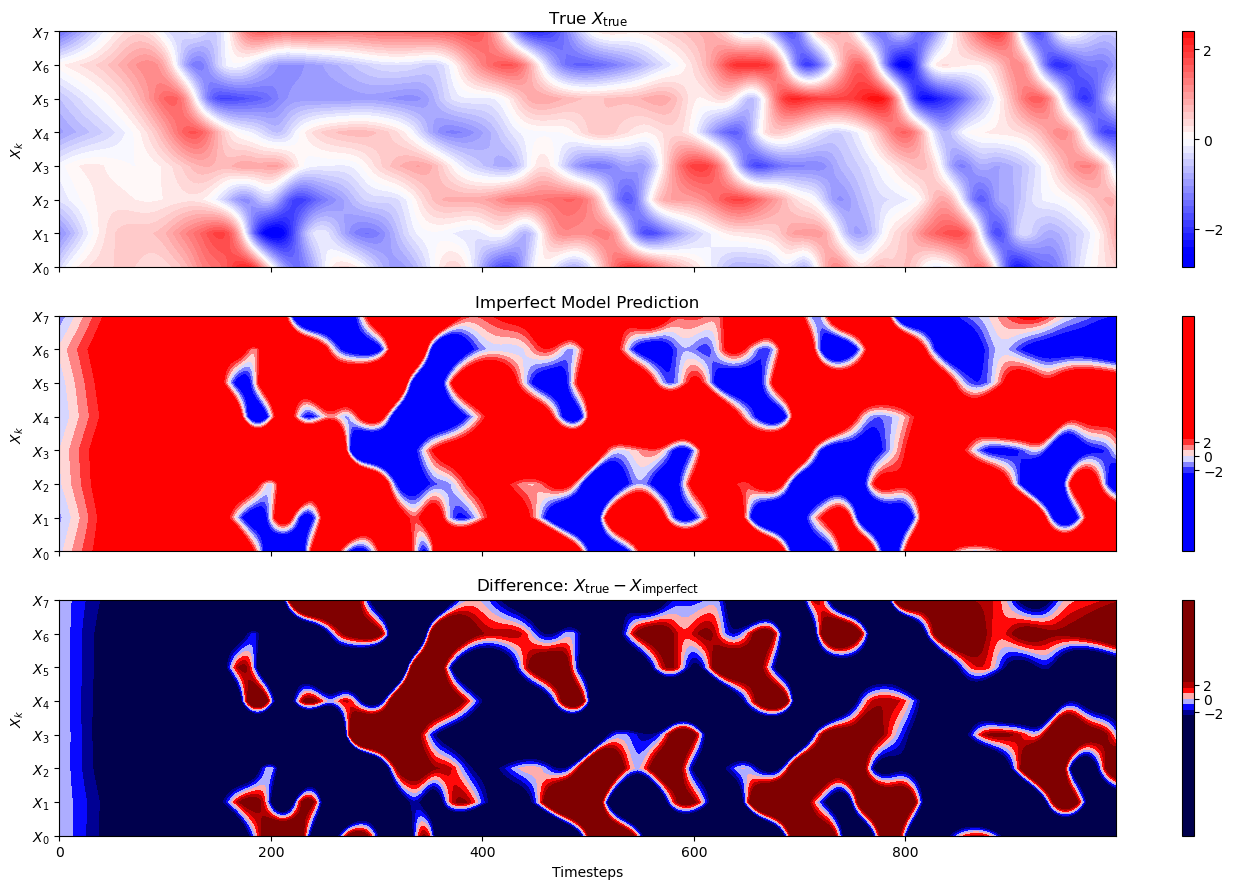

In [24]:
# === Load Data ===
df_true = pd.read_csv('./data/3tier_lorenz_v3.csv', header=None)
df_imperfect = pd.read_csv('./data/imperfect_predictions.csv', header=None)

# === Slice First 1000 Timesteps ===
steps = 1000
X_true = df_true.iloc[:steps].to_numpy().T
X_imperfect = df_imperfect.iloc[:steps].to_numpy().T
X_diff = X_true - X_imperfect

# === Axes ===
time_axis = np.arange(steps)
space_axis = np.arange(8)

# === Plotting ===
fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# --- True ---
c1 = axs[0].contourf(time_axis, space_axis, X_true, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
axs[0].set_title("True $X_{\\mathrm{true}}$")
axs[0].set_ylabel("$X_k$")
axs[0].set_yticks(space_axis)
axs[0].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
cb1 = fig.colorbar(c1, ax=axs[0])
cb1.set_ticks([-2, 0, 2])

# --- Imperfect Prediction ---
c2 = axs[1].contourf(time_axis, space_axis, X_imperfect, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
axs[1].set_title("Imperfect Model Prediction")
axs[1].set_ylabel("$X_k$")
axs[1].set_yticks(space_axis)
axs[1].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
cb2 = fig.colorbar(c2, ax=axs[1])
cb2.set_ticks([-2, 0, 2])

# --- Difference Plot ---
c3 = axs[2].contourf(time_axis, space_axis, X_diff, levels=50, cmap='seismic', vmin=-2.5, vmax=2.5)
axs[2].set_title("Difference: $X_{\\mathrm{true}} - X_{\\mathrm{imperfect}}$")
axs[2].set_xlabel("Timesteps")
axs[2].set_ylabel("$X_k$")
axs[2].set_yticks(space_axis)
axs[2].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
cb3 = fig.colorbar(c3, ax=axs[2])
cb3.set_ticks([-2, 0, 2])

plt.tight_layout()
plt.show()

In [25]:
# ===  Free memory ===
delete_variables(globals())
whos_memory(globals())

Deleted user variables and collected garbage.
Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0003
Out                  dict                0.0002
delete_variables     function            0.0002
trange               function            0.0002


### Reservoir Only

In [26]:
# === Config ===
SAVE_DIR = './checkpoints_reservoir/'
os.makedirs(SAVE_DIR, exist_ok=True)

# === Parameters ===
shift_k = 0  # Start index for initial condition
approx_res_size = 5000

model_params = {
    'tau': 0.25,
    'nstep': 1000,
    'N': 8,
    'd': 22
}

res_params = {
    'radius': 0.1,
    'degree': 3,
    'sigma': 0.5,
    'train_length': 100000,  # now 100k
    'N': int(np.floor(approx_res_size / model_params['N']) * model_params['N']),
    'num_inputs': model_params['N'],
    'predict_length': 10000,
    'beta': 0.0001
}


In [60]:
# === Reservoir Utilities ===
def generate_reservoir(size, radius, degree):
    print("Generating Reservoir")
    sparsity = degree / float(size)
    A = sparse.rand(size, size, density=sparsity).todense()
    eigvals = np.linalg.eigvals(A)
    A = (A / np.max(np.abs(eigvals))) * radius
    return A

def build_input_weights(N, num_inputs, sigma):
    q = int(N / num_inputs)
    Win = np.zeros((N, num_inputs))
    for i in tqdm(range(num_inputs), desc="building_Win"):
        np.random.seed(i)
        Win[i * q: (i + 1) * q, i] = sigma * (-1 + 2 * np.random.rand(q))
    return Win

def reservoir_layer(A, Win, data, res_params, start_step=1, states=None):
    N, T = res_params['N'], res_params['train_length']
    if states is None:
        states = np.zeros((N, T))
    for i in trange(start_step - 1, T - 1, desc="Training reservoir"):
        states[:, i + 1] = np.tanh(np.dot(A, states[:, i]) + np.dot(Win, data[:, i]))
        if (i + 1) % 10000 == 0:
            save_checkpoint(states[:, :i + 1], A, Win, i + 1)
    return states

def train(res_params, states, data):
    beta = res_params['beta']
    idenmat = beta * sparse.identity(res_params['N'])
    states2 = states.copy()
    for j in trange(2, states2.shape[0] - 2, desc="Training Wout"):
        if j % 2 == 0:
            states2[j, :] = states[j - 1, :] * states[j - 2, :]
    U = np.dot(states2, states2.T) + idenmat
    Wout = np.dot(np.linalg.inv(U), np.dot(states2, data.T))
    return Wout.T

def save_checkpoint(states, A, Win, step):
    checkpoint = {
        'states': states,
        'A': A,
        'Win': Win,
        'step': step
    }
    filename = os.path.join(SAVE_DIR, 'reservoir_checkpoint.pt')
    torch.save(checkpoint, filename, pickle_protocol=4)
    print(f"Saved checkpoint at step {step}: {filename}")

def load_latest_checkpoint():
    path = os.path.join(SAVE_DIR, 'reservoir_checkpoint.pt')
    if not os.path.exists(path):
        print("No checkpoint found. Starting fresh.")
        return None
    # with open(path, 'rb') as f:
    #     checkpoint = pickle.load(f)
    checkpoint = torch.load(path)
    print(f"Resuming from checkpoint at step {checkpoint['step']}")
    return checkpoint

def save_model(A, Win, Wout, final_state):
    model = {
        'A': A,
        'Win': Win,
        'Wout': Wout,
        'final_state': final_state
    }
    torch.save(model, os.path.join(SAVE_DIR, 'trained_reservoir_model.pt'), pickle_protocol=4)
    print("Full model saved.")

def predict(A, Win, res_params, x, Wout):
    output = np.zeros((res_params['num_inputs'],res_params['predict_length']))
    for i in tqdm(range(res_params['predict_length']), desc="Predicting"):
        x_aug = x.copy()
        for j in range(2,np.shape(x_aug)[0]-2):
            if (np.mod(j,2)==0):
                x_aug[j] = (x[j-1]*x[j-2]).copy()
        out = np.squeeze(np.asarray(np.dot(Wout,x_aug)))
        output[:,i] = out
        x1 = np.tanh(np.dot(A,x) + np.dot(Win,out))
        x = np.squeeze(np.asarray(x1))
    return output, x

In [28]:
# === Load True Data ===
dataf = pd.read_csv('./data/3tier_lorenz_v3.csv', header=None)
data = dataf.iloc[:, shift_k:shift_k + res_params['train_length']].to_numpy().T

In [54]:
# === Check Memory ===
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0005
Out                  dict                0.0002
delete_variables     function            0.0002
trange               function            0.0002
SAVE_DIR             str                 0.0001
shift_k              int                 0.0000
approx_res_size      int                 0.0000
model_params         dict                0.0002
res_params           dict                0.0003
generate_reservoir   function            0.0002
build_input_weights  function            0.0002
reservoir_layer      function            0.0002
train                function            0.0002
save_checkpoint      function            0.0002
load_latest_checkpoint function            0.0002
save_model           function            0.0002
predict              function            0.0002
dataf                DataFrame          61.0353
data                 ndarray       

In [41]:
# === Train Model ===
checkpoint = load_latest_checkpoint()
if checkpoint:
    A = checkpoint['A']
    Win = checkpoint['Win']
    states = np.zeros((res_params['N'], res_params['train_length']))
    start_step = checkpoint['states'].shape[1]
    states[:, :start_step] = checkpoint['states']
else:
    A = generate_reservoir(res_params['N'], res_params['radius'], res_params['degree'])
    Win = build_input_weights(res_params['N'], res_params['num_inputs'], res_params['sigma'])
    states = np.zeros((res_params['N'], res_params['train_length']))
    start_step = 1

states = reservoir_layer(A, Win, data, res_params, start_step, states)
Wout = train(res_params, states, data)
x = states[:, -1]

RuntimeError: PytorchStreamReader failed locating file data.pkl: file not found

In [43]:
SAVE_DIR = './checkpoints_reservoir/'
checkpoint_path = os.path.join(SAVE_DIR, 'reservoir_checkpoint.pt')

# Choose current step — if unknown, use the number of columns in states
step = states.shape[1]

# Create new checkpoint dictionary
checkpoint = {
    'states': states[:, :step],  # just in case it's longer than expected
    'A': A,
    'Win': Win,
    'step': step
}

# Save with PyTorch's default serialization (safe)
torch.save(checkpoint, checkpoint_path, pickle_protocol=4)
print(f"Overwritten checkpoint with step {step}: {checkpoint_path}")

Overwritten checkpoint with step 100000: ./checkpoints_reservoir/reservoir_checkpoint.pt


In [68]:
Wout = train(res_params, states, data[:, :states.shape[1]])

Training Wout: 100%|██████████| 4996/4996 [00:00<00:00, 10875.24it/s]


In [92]:
# Use the last known input (e.g., timestep 100000) to simulate one update
t_input = 100000  # the input index to simulate from

# Ensure shapes match
x_init = np.zeros((A.shape[0],))
x_init = np.tanh(np.dot(A, x_init) + np.dot(Win, data[:, t_input]))
x_init = np.squeeze(np.asarray(x_init))  # flatten to 1D (shape: [5000,])
x_init.shape


(5000,)

In [94]:
print("A shape:", A.shape)
print("Non-zero elements in A:", np.count_nonzero(A))
print("Fraction non-zero:", np.count_nonzero(A) / A.size)
print("A max value:", np.max(A))
print("A min value:", np.min(A))

A shape: (5000, 5000)
Non-zero elements in A: 15000
Fraction non-zero: 0.0006
A max value: 0.0669584610503272
A min value: 0.0


In [95]:
# === Prediction Test ===
output, _ = predict(A, Win, res_params, x_init, Wout)
np.save(os.path.join(SAVE_DIR, f'ESN_prediction_test_{res_params["train_length"]}.npy'), output)

Predicting:   0%|          | 0/10000 [00:00<?, ?it/s]

Predicting: 100%|██████████| 10000/10000 [05:10<00:00, 32.23it/s]


In [62]:
# === Save Final Model ===
save_model(A, Win, Wout, x)

Full model saved.


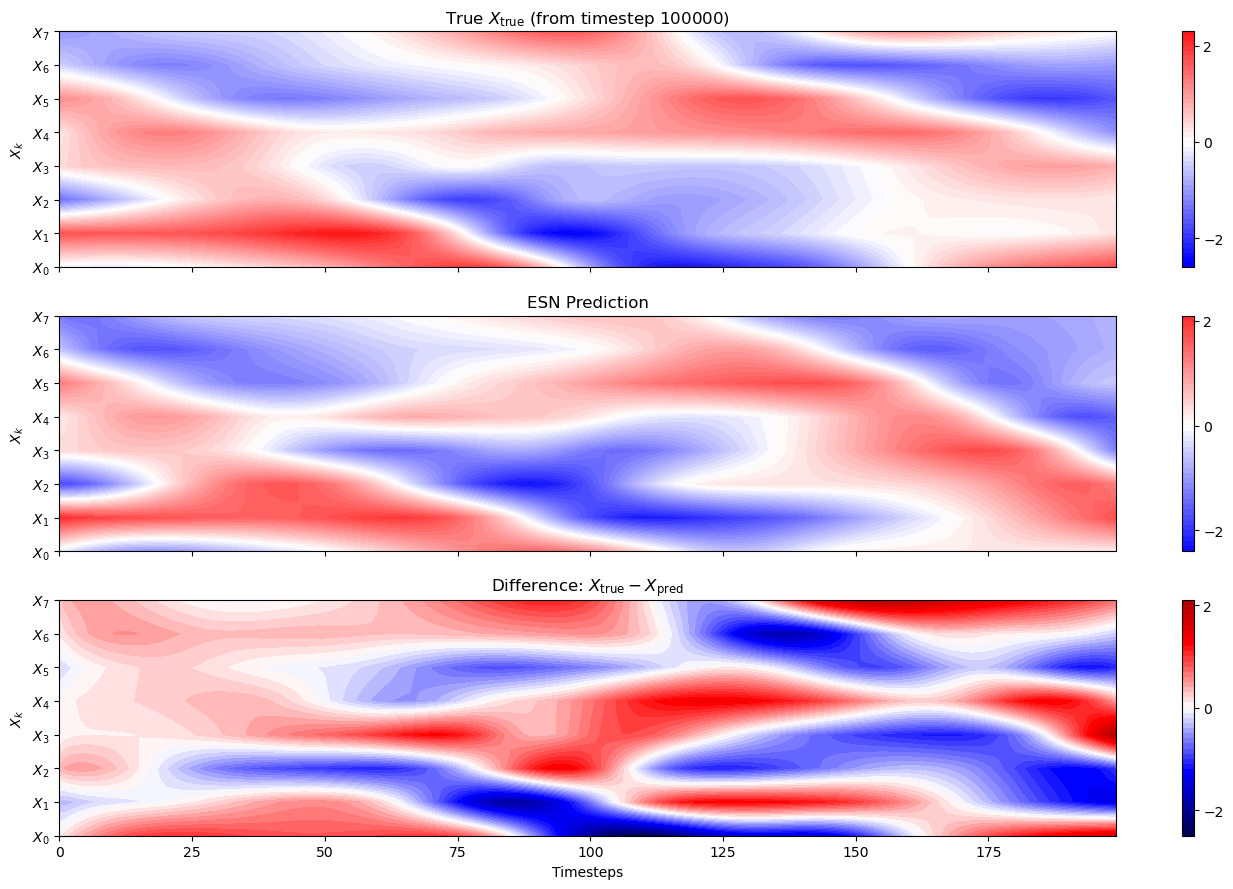

In [100]:
# === Load Data ===
df_true = pd.read_csv('./data/3tier_lorenz_v3.csv', header=None)
X_true_full = df_true.to_numpy().T  # shape: (8, N)

# === Slice True Data from timestep 100000 ===
start_t = 100000
steps = 200  # plot first 1000 steps of prediction
X_true = X_true_full[:, start_t:start_t + steps]
X_pred = output[:, :steps]
X_diff = X_true - X_pred

# === Axes ===
time_axis = np.arange(steps)
space_axis = np.arange(8)

# === Plotting ===
fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# --- True ---
c1 = axs[0].contourf(time_axis, space_axis, X_true, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
axs[0].set_title("True $X_{\\mathrm{true}}$ (from timestep 100000)")
axs[0].set_ylabel("$X_k$")
axs[0].set_yticks(space_axis)
axs[0].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
cb1 = fig.colorbar(c1, ax=axs[0])
cb1.set_ticks([-2, 0, 2])

# --- Predicted ---
c2 = axs[1].contourf(time_axis, space_axis, X_pred, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
axs[1].set_title("ESN Prediction")
axs[1].set_ylabel("$X_k$")
axs[1].set_yticks(space_axis)
axs[1].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
cb2 = fig.colorbar(c2, ax=axs[1])
cb2.set_ticks([-2, 0, 2])

# --- Difference ---
c3 = axs[2].contourf(time_axis, space_axis, X_diff, levels=50, cmap='seismic', vmin=-2.5, vmax=2.5)
axs[2].set_title("Difference: $X_{\\mathrm{true}} - X_{\\mathrm{pred}}$")
axs[2].set_xlabel("Timesteps")
axs[2].set_ylabel("$X_k$")
axs[2].set_yticks(space_axis)
axs[2].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
cb3 = fig.colorbar(c3, ax=axs[2])
cb3.set_ticks([-2, 0, 2])

plt.tight_layout()
plt.show()

In [101]:
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0009
Out                  dict                0.0011
delete_variables     function            0.0002
trange               function            0.0002
SAVE_DIR             str                 0.0001
shift_k              int                 0.0000
approx_res_size      int                 0.0000
model_params         dict                0.0002
res_params           dict                0.0003
generate_reservoir   function            0.0002
build_input_weights  function            0.0002
reservoir_layer      function            0.0002
train                function            0.0002
save_checkpoint      function            0.0002
load_latest_checkpoint function            0.0002
save_model           function            0.0002
predict              function            0.0002
dataf                DataFrame          61.0353
data                 ndarray       

In [102]:
# === Save Reservoir Model Components Individually ===
np.save(os.path.join(SAVE_DIR, 'A_matrix.npy'), A)
np.save(os.path.join(SAVE_DIR, 'Win_matrix.npy'), Win)
np.save(os.path.join(SAVE_DIR, 'Wout_matrix.npy'), Wout)
np.save(os.path.join(SAVE_DIR, 'final_state.npy'), x_init)
    
print("All components saved as individual files.")

All components saved as individual files.


In [105]:
np.savez_compressed('./checkpoints_reservoir/A_matrix_compressed.npz', A=A)

In [106]:
print(os.path.getsize('./checkpoints_reservoir/A_matrix_compressed.npz') / (1024**2), 'MB')

0.3529796600341797 MB


In [107]:
with np.load('./checkpoints_reservoir/A_matrix_compressed.npz') as data:
    A = data['A']
Win = np.load(os.path.join(SAVE_DIR, 'Win_matrix.npy'), allow_pickle=True)
Wout = np.load(os.path.join(SAVE_DIR, 'Wout_matrix.npy'), allow_pickle=True)
x = np.load(os.path.join(SAVE_DIR, 'final_state.npy'), allow_pickle=True)

In [109]:
print("Shape:", A.shape)
print("Max:", A.max())
print("Min:", A.min())
print("Fraction nonzero:", np.count_nonzero(A) / A.size)

Shape: (5000, 5000)
Max: 0.0669584610503272
Min: 0.0
Fraction nonzero: 0.0006


In [ ]:
output, _ = predict(A, Win, res_params, x_init, Wout)
